In [8]:
import deap
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


# Parametros del problema

In [ ]:
L = 1
g = 9.81
m = 0.25


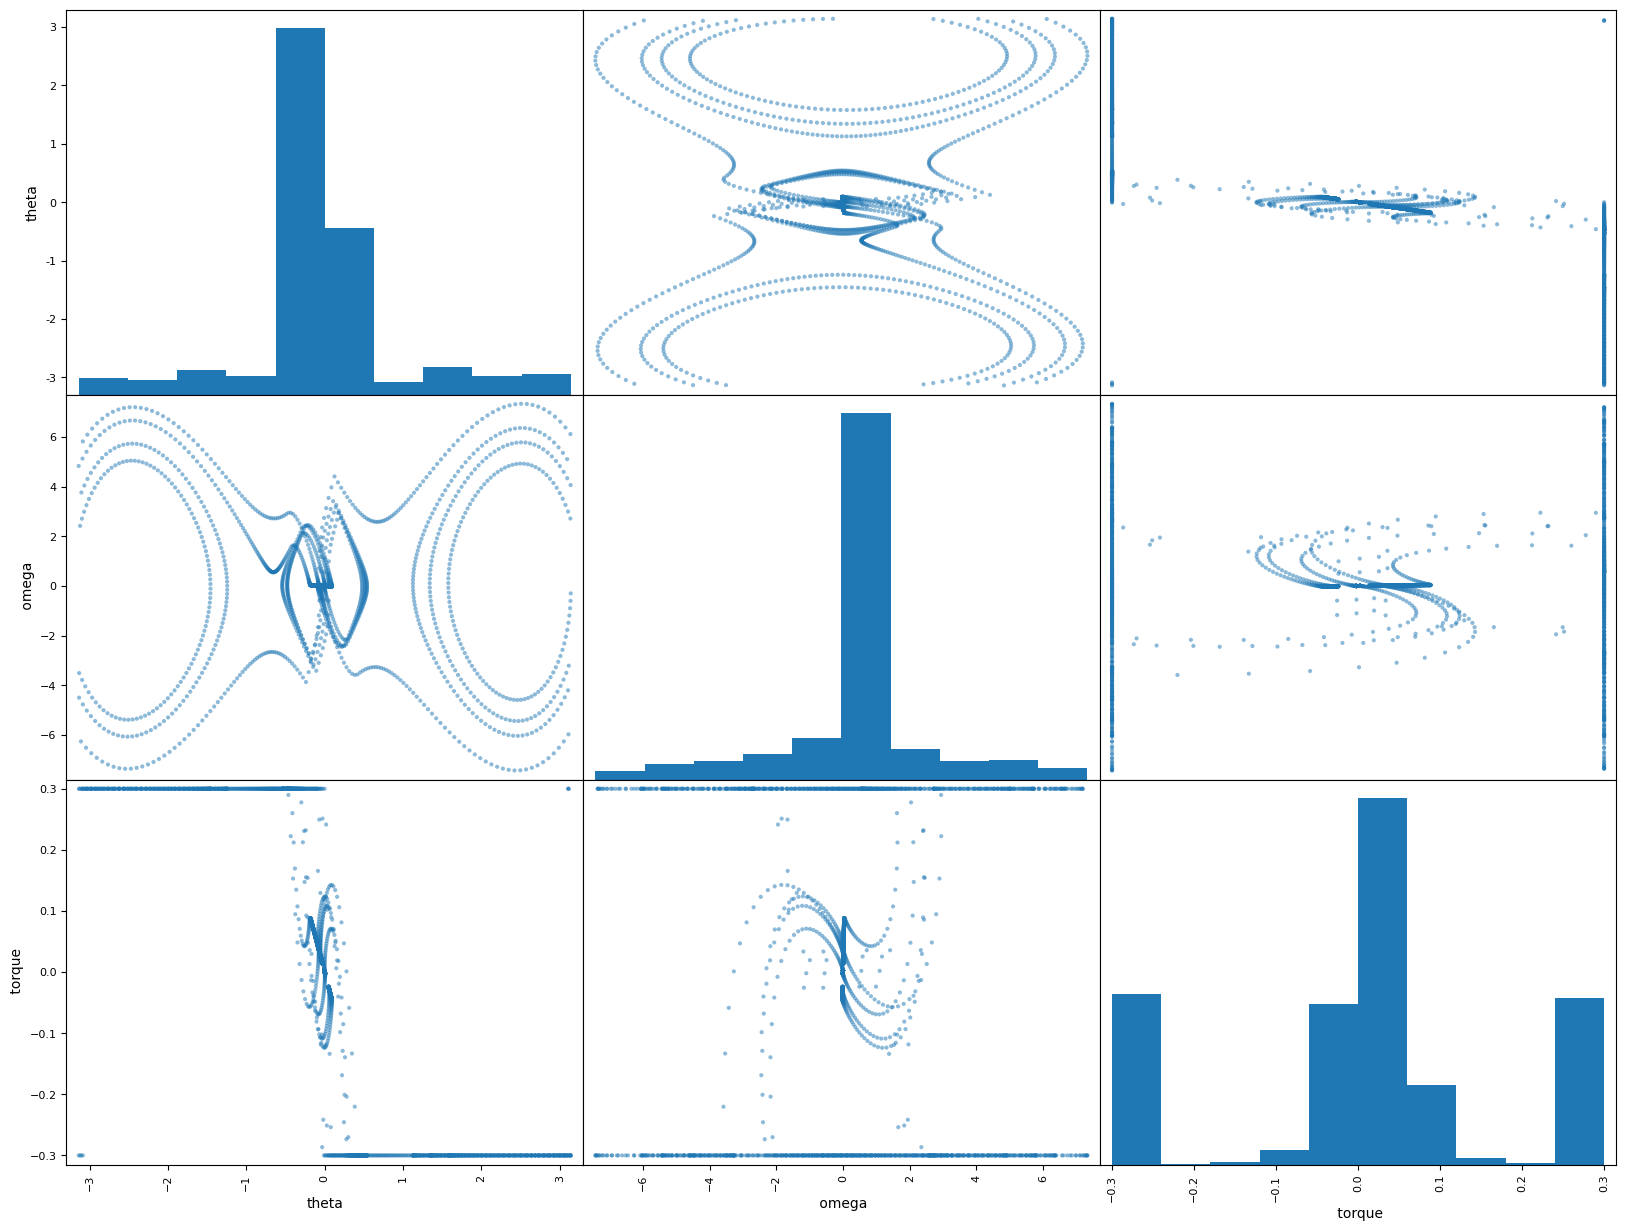

In [9]:
dataset = pd.read_csv('dataset.csv')

pd.plotting.scatter_matrix(dataset, figsize=(20, 15))
plt.show()

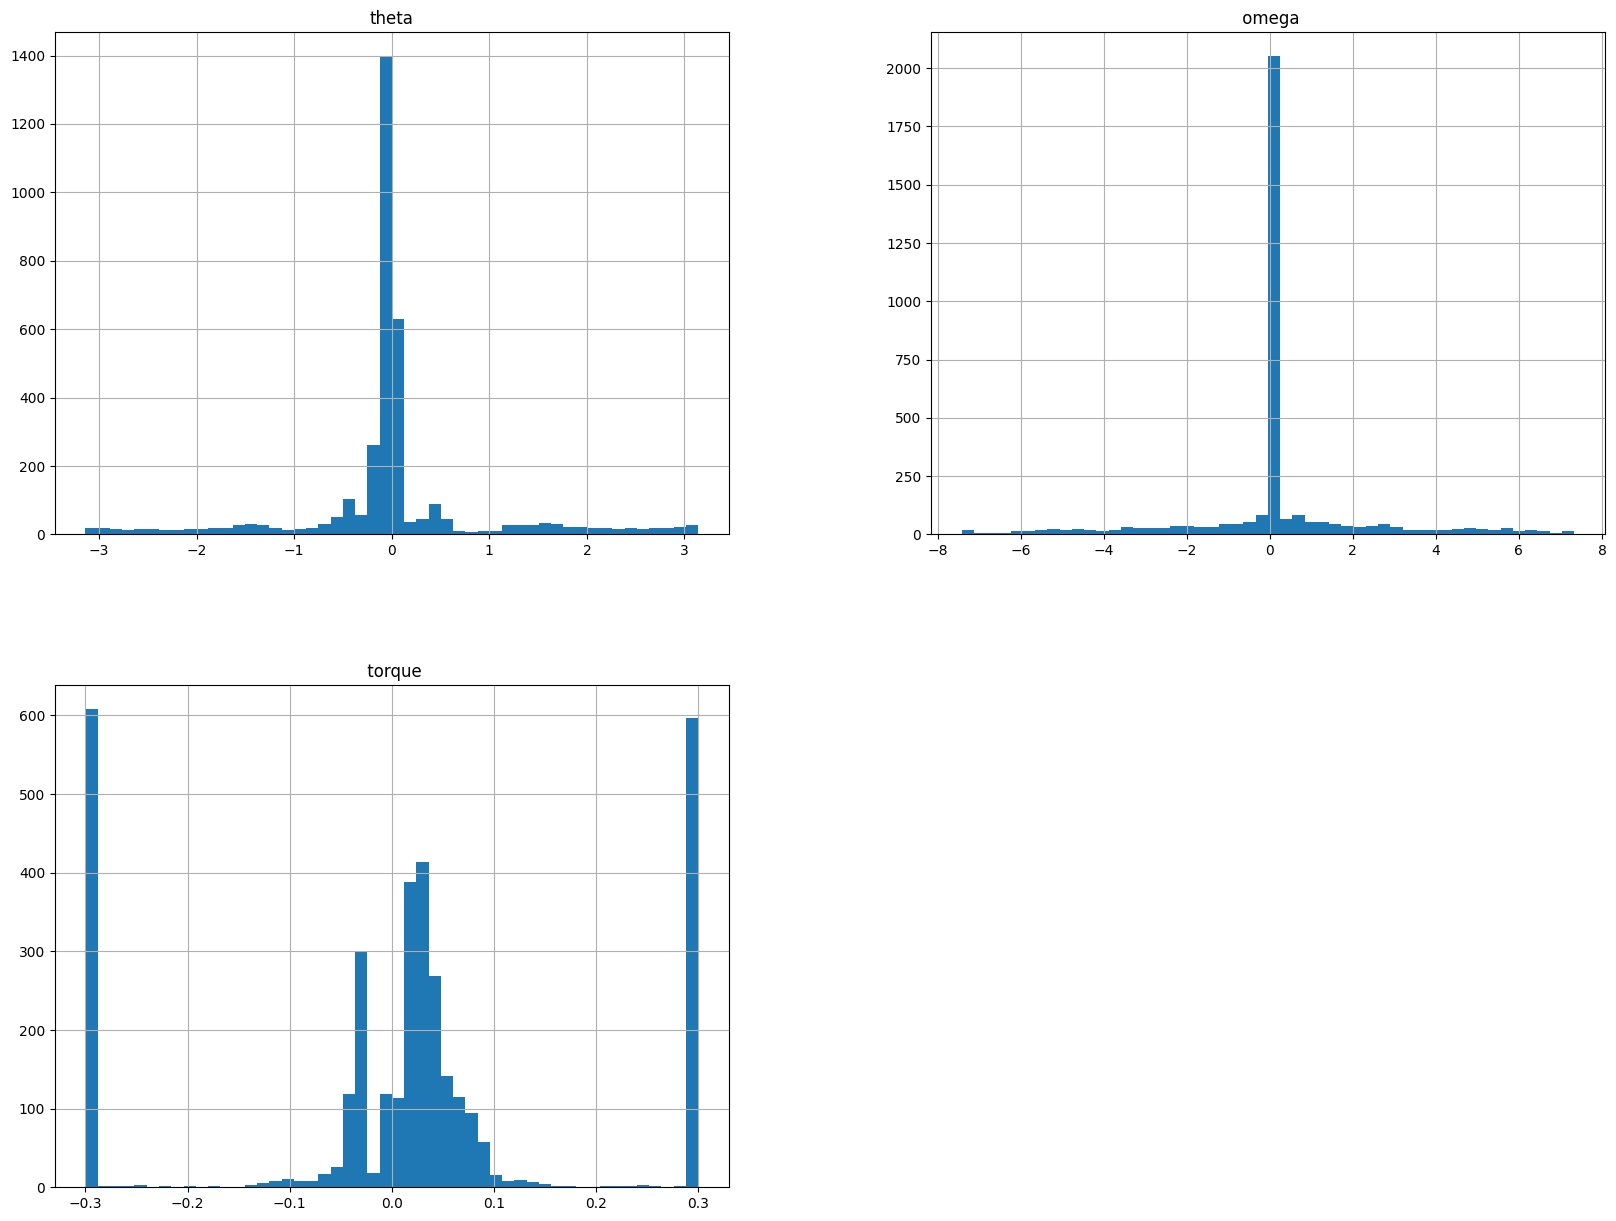

In [7]:
dataset.hist(figsize=(20, 15), bins=50) #Se observa la frecuencia de cada uno de los valores de las variables
plt.show()

In [ ]:
trainset = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(trainset.index)

# BURN, ESTOS SE USAN PARA ENTRENAR LA RED CON DESCENSO DE GRADIENTE, Y
# EN LA PRUEBA DE HIPER PARAMETROS. NO SE USAN PARA EL ALGORITMO EVOLUTIVO
X_train = train_set.iloc[:, :2].values
Y_train = train_set.iloc[:, 2:].values

X_test = test_set.iloc[:, :2].values
Y_test = test_set.iloc[:, 2:].values

# Parameters
batch_size = 32

# ESTOS SE USAN PARA EL ALGORITMO EVOLUTIVO
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

In [ ]:
class HyperParamTuner(kt.HyperModel):

    def build(self, hp):
        '''
        Construye el modelo de la red. hp es un parametro que permite que
        la clase de keras tuner pueda modificar los parametros del modelo
        automáticamente.
        '''
        # Se genera una capa de normalización, la cual
        # normaliza las entradas de la red
        norm_layer = tf.keras.layers.Normalization(axis=-1)
        # Se entrena con los datos de entrenamiento
        norm_layer.adapt(np.array(trainset_X))

        # se inicializa un modelo secuencial, y se le adiciona la capa
        # de normalización como la primera capa de la red
        model = keras.Sequential()
        model.add(norm_layer)
        # Se definen los hiperparametros, así como
        # los valores que pueden tomar
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        activation_function = hp.Choice(
            'activation_function', values=['tanh', 'sigmoid'])

        num_units = hp.Int('num_neurons',
                           min_value=3,
                           max_value=6,
                           step=1)
        for i in range(num_layers):
            model.add(layers.Dense(num_units,
                                   activation=activation_function))

        # Se adiciona la capa de salida
        model.add(layers.Dense(1, activation='linear'))
        # Se establece como hiperparametro la función de pérdida
        loss_func = hp.Choice('loss_function', values=['mse', 'mae'])

        model.compile(
            optimizer=keras.optimizers.Adam(
                # permite poner la taza de aprendizaje como hiperparametro
                hp.Choice('learning_rate', [1e-2, 1.5e-2, 1e-3, 1.5e-3, 1e-4])),
            loss=loss_func,
            metrics=['mae'])
        return model

    def fit(self, hp, model, trainset_X,
            trainset_Y,
            epochs=200,
            # validation_split=test_percentage,
            validation_data=(valset_X, valset_Y),
            # termina el entrenamiento si no hay mejora en la función de pérdida
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_mae', patience=5)],
            verbose=False):

        # Se coloca el batchsize como hiperparametro
        batch = hp.Int('batch_size', min_value=5, max_value=150, step=15)
        return model.fit(
            trainset_X,
            trainset_Y,
            epochs=1000,
            batch_size=batch,
            # validation_split=test_percentage,
            validation_data=(valset_X, valset_Y),
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_mae', patience=5)],
            verbose=False)

In [ ]:
tuner = kt.RandomSearch(
    HyperParamTuner(),
    objective='val_mae',  # Se busca minimizar el error absoluto medio
    max_trials=25,  # Número de combinaciones de hiperparámetros a probar
    # Número de veces que se entrena cada combinación de hiperparámetros. De esta forma se
    executions_per_trial=2,
    # evita que si en un entrenamiento se obtiene un resultado muy bueno o muy malo, se actúe
    # inmediatamente sobre esa información, ya que ese resultado pudo haber ocurrido por suerte.
    directory='tests',
    project_name='Field Current',
    overwrite=False)


tuner.search_space_summary()

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    mode='min',
    patience=5
)
# Se inicia la búsqueda de hiperparámetros
tuner.search(trainset_X,
             trainset_Y,
             epochs=1000,
             # validation_split=test_percentage,
             validation_data=(valset_X, valset_Y),
             callbacks=[stop_early],

             verbose=False)

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # Se obtienen los mejores hiperparámetros``
print("Best hyperparameters:", best_hps.values)

In [ ]:
history = model.fit(trainset_X,
                    trainset_Y,
                    epochs=1000,
                    batch_size=best_hps.get('batch_size'),
                    validation_split=0.2,  # Use validation data
                    callbacks=[stop_early],
                    verbose=False)


test_loss, test_mae = model.evaluate(testset_X, testset_Y, verbose=0)
print(f'Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}')
loss_df = pd.DataFrame(history.history)
print(loss_df.head())
# Plot the loss and validation loss
loss_df.loc[:, ['mae', 'val_mae']].plot()
plt.ylim(0, 1)
plt.title('Error Absoluto')
plt.xlabel('Epochs')
plt.ylabel('Error Absoluto')
plt.grid()

# $Individuo = [W_1, B_1, W_2, B_2]$

In [ ]:
def WeightsPlacer(individual, tuner):
    '''
    Toma los pesos, que se encuentran en el individuo
    y los convierte en forma tensorial para poder
    ser colocados en el modelo
    '''
    best_config = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_config) 
    idx = 0
    tensors=[]
    for layer in model.layers[1:]: #Excluye la capa Normalizadora, que ya se entrenó
        for weight_arr in layer.get_weights():

            size = weight_arr.size

            shape = weight_arr.shape
            tensor = individual[idx:idx+size]
            
            tensor = np.array(tensor)
            tensor = np.reshape(tensor, shape)

            idx += size

            tensors.append(tensor)

    model.set_weights(tensors)

    return model

def Fitness_Function(individual, train_dataset, batch_size, step):
    #Create the model
     #CHANGE THIS BUILD USING HYPERPARMS
    #Set the weights

    model = WeightsPlacer(individual)

    #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    (x_batch_train, y_batch_train) = train_dataset
    
    current_batch_X = x_batch_train[step*batch_size:(step+1)*batch_size]
    current_batch_Y = y_batch_train[step*batch_size:(step+1)*batch_size]

    mae_per_batch = np.abs(model.predict(x_batch_train) - y_batch_train)

    Average_training_torque_error = np.mean(mae_per_batch) 

    return Average_training_torque
             

In [ ]:
def Training_Loop(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,train_dataset, batch_size, step,
                   stats=None, halloffame=None, verbose=__debug__ ):
    r"""This is the :math:`(\mu + \lambda)` evolutionary algorithm.

    :param population: A list of individuals.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param mu: The number of individuals to select for the next generation.
    :param lambda\_: The number of children to produce at each generation.
    :param cxpb: The probability that an offspring is produced by crossover.
    :param mutpb: The probability that an offspring is produced by mutation.
    :param ngen: The number of generation.
    :param stats: A :class:`~deap.tools.Statistics` object that is updated
                  inplace, optional.
    :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                       contain the best individuals, optional.
    :param verbose: Whether or not to log the statistics.
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution.

    The algorithm takes in a population and evolves it in place using the
    :func:`varOr` function. It returns the optimized population and a
    :class:`~deap.tools.Logbook` with the statistics of the evolution. The
    logbook will contain the generation number, the number of evaluations for
    each generation and the statistics if a :class:`~deap.tools.Statistics` is
    given as argument. The *cxpb* and *mutpb* arguments are passed to the
    :func:`varOr` function. The pseudocode goes as follow ::

        evaluate(population)
        for g in range(ngen):
            offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)
            evaluate(offspring)
            population = select(population + offspring, mu)

    First, the individuals having an invalid fitness are evaluated. Second,
    the evolutionary loop begins by producing *lambda_* offspring from the
    population, the offspring are generated by the :func:`varOr` function. The
    offspring are then evaluated and the next generation population is
    selected from both the offspring **and** the population. Finally, when
    *ngen* generations are done, the algorithm returns a tuple with the final
    population and a :class:`~deap.tools.Logbook` of the evolution.

    This function expects :meth:`toolbox.mate`, :meth:`toolbox.mutate`,
    :meth:`toolbox.select` and :meth:`toolbox.evaluate` aliases to be
    registered in the toolbox. This algorithm uses the :func:`varOr`
    variation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = []
    curr_step = 0
    for ind in invalid_ind:
        fitnesses.append(Fitness_Function(ind, train_dataset, batch_size, curr_step))

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        fitnesses = []
        for ind in invalid_ind:
            fitnesses.append(Fitness_Function(ind, train_dataset, batch_size, gen))
            
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [ ]:
lower = -25 #
upper = 25
tournament_size = 3

In [ ]:
toolbox = base.Toolbox()
creator.create("Fitness_Mono", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness_Mono)
# Se añaden las operaciones necesarias para la creacion de individuos y poblacion,
# asi como la funcion de evaluacion.

toolbox.register("P", random.uniform, lower, upper) #Esto genera las entradas del individuo. P de parameter
toolbox.register("individual", tools.initCycle,
                 creator.Individual, toolbox.P, n=24) #ESTO SE VE CON LOS HIPERPARAMETROS!!!!!!
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, n=population_size)

def checkBounds(min1, max1):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                # Check the first gene (index 0)
                if child[0] > max1:
                    child[0] = max1
                elif child[0] < min1:
                    child[0] = min1
            return offspring
        return wrapper
    return decorator
toolbox.register("mate", tools.cxBlend, alpha=alpha)
toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=tournament_size)
toolbox.decorate("mate", checkBounds(lower, upper))
toolbox.decorate("mutate", checkBounds(lower, upper))

In [ ]:
# Estadísticas del fitness general de la población
# Codigo proporcionado en las guias del curso
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # Promedio de la gen
stats.register("std", np.std)  # Desviación estándar de los individuos
stats.register("min", np.min)  # Fitness mínimo de la gen
stats.register("max", np.max)  # Fitness máximo de la gen

In [ ]:
hof = tools.HallOfFame()
population = toolbox.population()
evolved_population, logbook = Training_Loop(
    population=population,
    toolbox=toolbox,
    mu=parent_popu_size,
    lambda_=child_popu_size,
    cxpb=mate_probability,
    mutpb=mutate_probability,
    ngen=generations,
    stats=stats,
    halloffame=hof
)

In [ ]:
best_individual = tools.selBest(evolved_population, k=1)[0]

modelo_a_utilizar = Weights_Placer(best_individual, tuner)

test_loss, test_mae = modelo_a_utilizar.evaluate(testset_X, testset_Y, verbose=0)
print(f'Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}')



In [ ]:
modelo_a_utilizar.save("TrainedModel.keras", overwrite=True) # Se guarda el modelo de rendimiento satisfactorio.

In [ ]:

def step_point_mass_pendulum(theta, omega, tau, dt, m=1.0, l=1.0, g=9.81):
    """
    Compute next theta, omega, alpha for an inverted pendulum with a point mass.

    Parameters:
        theta (float): Angle (rad)
        omega (float): Angular velocity (rad/s)
        tau (float): Applied torque (N·m)
        dt (float): Time step (s)
        m (float): Mass (kg)
        l (float): Length (m)
        g (float): Gravity (m/s²)

    Returns:
        theta_next (float)
        omega_next (float)
        alpha_next (float)
    """
    def dynamics(t, y):
        posicion_angular, velocidad_angular = y
        aceleracion_angular = (tau / (m * l**2)) - (g / l) * np.sin(θ)
        return [velocidad_angular, aceleracion_angular]

    sol = solve_ivp(
        dynamics,
        t_span=(0, dt),
        y0=[theta, omega],
        method='RK45',
        t_eval=[dt]
    )

    theta_next, omega_next = sol.y[:, -1]
    alpha_next = (tau / (m * l**2)) - (g / l) * np.sin(theta_next)

    return theta_next, omega_next, alpha_next
